## Load results for each method

In [214]:
import pandas as pd

df_cot = pd.read_csv("results/cot_few-shot/cot_few-shot_results_2025-03-27_13-55-58.csv")
df_cove = pd.read_csv("results/cove_few-shot/cove_few-shot_results_2025-03-27_14-42-13.csv")
df_self_refine = pd.read_csv("results/self-refine_few-shot/self-refine_few-shot_results_2025-03-27_15-08-17.csv")

### Rename columns before merging

In [215]:
df_cot = df_cot.rename(columns={"predicted": "predicted_cot"})
df_cove = df_cove.rename(columns={"predicted": "predicted_cove"})
df_self_refine = df_self_refine.rename(columns={"predicted": "predicted_sr"})

### Merge results on question ID

In [232]:
df_all = df_cot[["id", "subject", "ground_truth", "predicted_cot"]].merge(
    df_cove[["id", "predicted_cove"]],
    on="id"
).merge(
    df_self_refine[["id", "predicted_sr"]],
    on="id"
)

## Calculate Accuracy

### Add correctness flags for each method

In [233]:
df_all["correct_cot"] = df_all["predicted_cot"] == df_all["ground_truth"]
df_all["correct_cove"] = df_all["predicted_cove"] == df_all["ground_truth"]
df_all["correct_sr"] = df_all["predicted_sr"] == df_all["ground_truth"]

### Calculate accuracy for each method

In [234]:
# Calculate subject-wise accuracy
subject_acc = (
    df_all.groupby("subject")[["correct_cot", "correct_cove", "correct_sr"]]
    .mean()
    .round(3)
    .rename(columns={
        "correct_cot": "CoT",
        "correct_cove": "CoVe",
        "correct_sr": "Self-Refine"
    })
)

# Calculate general accuracy
general_accuracy = df_all[["correct_cot", "correct_cove", "correct_sr"]].mean().round(3)
general_accuracy.index = ["CoT", "CoVe", "Self-Refine"]

# Append general accuracy as a new row
subject_acc.loc["General Accuracy"] = general_accuracy

display(subject_acc)

,CoT,CoVe,Self-Refine
subject,,,
Ciências Humanas e suas Tecnologias,0.978,0.911,0.933
Ciências da Natureza e suas Tecnologias,0.533,0.556,0.556
"Linguagens, Códigos e suas Tecnologias",0.756,0.844,0.800
Matemática e suas Tecnologias,0.422,0.378,0.511
General Accuracy,0.672,0.672,0.700


### Visualize Accuracy per Subject

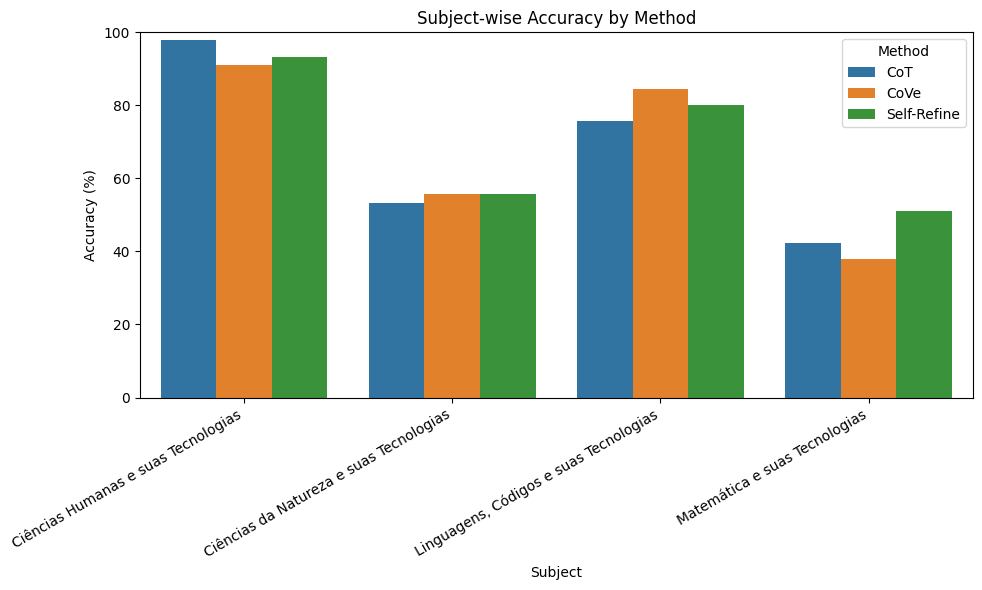

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the general accuracy row for subject-wise plot (optional)
plot_df = subject_acc.drop("General Accuracy").reset_index().melt(
    id_vars="subject", var_name="Method", value_name="Accuracy"
)

# Convert accuracy to percentage
plot_df["Accuracy"] *= 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x="subject", y="Accuracy", hue="Method")

plt.title("Subject-wise Accuracy by Method")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.xlabel("Subject")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

## Analyse Regressions (correct -> wrong) and Improvements (wrong -> correct)

### CoVe

#### Define regressions and improvements

In [239]:
df_cove["regression"] = (
    (df_cove["initial_answer"] == df_cove["ground_truth"]) &
    (df_cove["predicted_cove"] != df_cove["ground_truth"])
)

df_cove["improvement"] = (
    (df_cove["initial_answer"] != df_cove["ground_truth"]) &
    (df_cove["predicted_cove"] == df_cove["ground_truth"])
)

df_cove["changed_initial_answer"] = (
    df_cove["initial_answer"] != df_cove["predicted_cove"]
)

#### Calculate total regressions (first correct then wrong) and improvements (first wrong then correct)

In [240]:
n_total_cove = len(df_cove)
n_regress_cove = df_cove["regression"].sum()
n_improve_cove = df_cove["improvement"].sum()

#### 📊 CoVe – Regressions and Improvements per Subject

In [241]:
subject_summary_cove = df_cove.groupby("subject").agg(
    total_questions=("id", "count"),
    changes=("changed_initial_answer", "sum"),
    regressions=("regression", "sum"),
    improvements=("improvement", "sum")
).reset_index()

display(subject_summary_cove)


,subject,total_questions,changes,regressions,improvements
0,Ciências Humanas e suas Tecnologias,45,0,0,0
1,Ciências da Natureza e suas Tecnologias,45,3,1,0
2,"Linguagens, Códigos e suas Tecnologias",45,1,0,0
3,Matemática e suas Tecnologias,45,11,3,0


### Self-Refine

#### Extract and normalize answers

In [223]:
df_self_refine["initial_answer"] = df_self_refine["answer_sequence"].apply(
    lambda seq: seq[0] if seq else None
)

df_self_refine["answer_sequence_normalized"] = df_self_refine["answer_sequence"].apply(
    lambda seq: [str(a).strip().upper() for a in seq]
)

df_self_refine["ground_truth_normalized"] = df_self_refine["ground_truth"].str.strip().str.upper()
df_self_refine["predicted_normalized"] = df_self_refine["predicted_sr"].str.strip().str.upper()


#### Set regression and improvement flags

In [224]:
df_self_refine["regression"] = (
    df_self_refine.apply(
        lambda row: row["ground_truth_normalized"] in row["answer_sequence_normalized"]
        and row["predicted_normalized"] != row["ground_truth_normalized"],
        axis=1
    )
)

df_self_refine["improvement"] = (
    (df_self_refine["initial_answer"].str.strip().str.upper() != df_self_refine["ground_truth_normalized"]) &
    (df_self_refine["predicted_normalized"] == df_self_refine["ground_truth_normalized"])
)

df_self_refine.head()

,id,question,ground_truth,predicted_sr,correct,baseline_answer,final_answer,answer_sequence,trace,subject,initial_answer,answer_sequence_normalized,ground_truth_normalized,predicted_normalized,regression,improvement
0,questao_01,"## Holy War\nOh, so we can hate each other and...",A,A,True,"A expressão ""instead of"" é um marcador que int...","A expressão ""instead of"" é um marcador que int...",['A'],"[('A expressão ""instead of"" é um marcador que ...","Linguagens, Códigos e suas Tecnologias",[,"[[, ', A, ', ]]",A,A,False,True
1,questao_02,[[placeholder]]\nO texto estabelece uma relaçã...,A,D,False,"Para responder a essa pergunta, devemos analis...","Para responder a essa pergunta, devemos analis...",['D'],"[('Para responder a essa pergunta, devemos ana...","Linguagens, Códigos e suas Tecnologias",[,"[[, ', D, ', ]]",A,D,False,False
2,questao_03,[[placeholder]]\nA relação entre as citações a...,C,C,True,"Para responder a essa pergunta, devemos analis...","Para responder a essa pergunta, devemos analis...",['C'],"[('Para responder a essa pergunta, devemos ana...","Linguagens, Códigos e suas Tecnologias",[,"[[, ', C, ', ]]",C,C,False,True
3,questao_04,[[placeholder]]A carta da editora Stephanie Al...,E,E,True,"Para responder a essa pergunta, devemos analis...",Analisando a carta da editora Stephanie Allen-...,"['D', 'E']","[('Para responder a essa pergunta, devemos ana...","Linguagens, Códigos e suas Tecnologias",[,"[[, ', D, ', ,, , ', E, ', ]]",E,E,False,True
4,questao_05,## Borderlands/La frontera: the Nem Mestiza\nG...,A,A,True,"Neste texto, Glória Anzaldúa aborda o problema...","Neste texto, Glória Anzaldúa aborda o problema...",['A'],"[('Neste texto, Glória Anzaldúa aborda o probl...","Linguagens, Códigos e suas Tecnologias",[,"[[, ', A, ', ]]",A,A,False,True


#### Analyse dynamics of answer sequence

##### Calculate number of iterations and changes

In [225]:
df_self_refine["initial_answer"] = df_self_refine["answer_sequence"].apply(lambda seq: seq[0] if seq else None)

df_self_refine["num_iterations"] = df_self_refine["answer_sequence"].apply(len)

df_self_refine["num_changes"] = df_self_refine["answer_sequence"].apply(
    lambda seq: sum(seq[i] != seq[i-1] for i in range(1, len(seq)))
)
df_self_refine["changed_initial_answer"] = (
    df_self_refine["initial_answer"] != df_self_refine["predicted_sr"]
)

df_self_refine

,id,question,ground_truth,predicted_sr,correct,baseline_answer,final_answer,answer_sequence,trace,subject,initial_answer,answer_sequence_normalized,ground_truth_normalized,predicted_normalized,regression,improvement,num_iterations,num_changes,changed_initial_answer
0,questao_01,"## Holy War\nOh, so we can hate each other and...",A,A,True,"A expressão ""instead of"" é um marcador que int...","A expressão ""instead of"" é um marcador que int...",['A'],"[('A expressão ""instead of"" é um marcador que ...","Linguagens, Códigos e suas Tecnologias",[,"[[, ', A, ', ]]",A,A,False,True,5,4,True
1,questao_02,[[placeholder]]\nO texto estabelece uma relaçã...,A,D,False,"Para responder a essa pergunta, devemos analis...","Para responder a essa pergunta, devemos analis...",['D'],"[('Para responder a essa pergunta, devemos ana...","Linguagens, Códigos e suas Tecnologias",[,"[[, ', D, ', ]]",A,D,False,False,5,4,True
2,questao_03,[[placeholder]]\nA relação entre as citações a...,C,C,True,"Para responder a essa pergunta, devemos analis...","Para responder a essa pergunta, devemos analis...",['C'],"[('Para responder a essa pergunta, devemos ana...","Linguagens, Códigos e suas Tecnologias",[,"[[, ', C, ', ]]",C,C,False,True,5,4,True
3,questao_04,[[placeholder]]A carta da editora Stephanie Al...,E,E,True,"Para responder a essa pergunta, devemos analis...",Analisando a carta da editora Stephanie Allen-...,"['D', 'E']","[('Para responder a essa pergunta, devemos ana...","Linguagens, Códigos e suas Tecnologias",[,"[[, ', D, ', ,, , ', E, ', ]]",E,E,False,True,10,9,True
4,questao_05,## Borderlands/La frontera: the Nem Mestiza\nG...,A,A,True,"Neste texto, Glória Anzaldúa aborda o problema...","Neste texto, Glória Anzaldúa aborda o problema...",['A'],"[('Neste texto, Glória Anzaldúa aborda o probl...","Linguagens, Códigos e suas Tecnologias",[,"[[, ', A, ', ]]",A,A,False,True,5,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,questao_176,"Atualmente, há telefones celulares com telas d...",D,D,True,Para encontrar a diferença de tamanho entre as...,Para encontrar a diferença de tamanho entre as...,['D'],[('Para encontrar a diferença de tamanho entre...,Matemática e suas Tecnologias,[,"[[, ', D, ', ]]",D,D,False,True,5,4,True
176,questao_177,Uma imobiliária iniciou uma campanha de divulg...,A,B,False,Para encontrar o mês mais adequado para o clie...,Para encontrar o mês mais adequado para o clie...,['B'],[('Para encontrar o mês mais adequado para o c...,Matemática e suas Tecnologias,[,"[[, ', B, ', ]]",A,B,False,False,5,4,True
177,questao_178,"Um professor de desenho, apresentou uma peça d...",D,D,True,"Para encontrar a escala utilizada no desenho, ...","Para encontrar a escala utilizada no desenho, ...",['D'],[('Para encontrar a escala utilizada no desenh...,Matemática e suas Tecnologias,[,"[[, ', D, ', ]]",D,D,False,True,5,4,True
178,questao_179,A prefeitura de uma cidade planeja construir t...,C,C,True,Para que os postos de saúde sejam equidistante...,Para que os postos de saúde sejam equidistante...,['C'],[('Para que os postos de saúde sejam equidista...,Matemática e suas Tecnologias,[,"[[, ', C, ', ]]",C,C,False,True,5,4,True


##### Checkout cases where the model changed its initial answer

In [226]:
df_self_refine[df_self_refine["changed_initial_answer"]][
    ["id", "initial_answer", "predicted_sr", "ground_truth", "answer_sequence", "improvement", "regression"]
]

,id,initial_answer,predicted_sr,ground_truth,answer_sequence,improvement,regression
0,questao_01,[,A,A,['A'],True,False
1,questao_02,[,D,A,['D'],False,False
2,questao_03,[,C,C,['C'],True,False
3,questao_04,[,E,E,"['D', 'E']",True,False
4,questao_05,[,A,A,['A'],True,False
...,...,...,...,...,...,...,...
175,questao_176,[,D,D,['D'],True,False
176,questao_177,[,B,A,['B'],False,False
177,questao_178,[,D,D,['D'],True,False
178,questao_179,[,C,C,['C'],True,False


##### Changed and improved, changed and regressed

In [227]:
df_self_refine["changed_and_improved"] = (
    df_self_refine["changed_initial_answer"] & df_self_refine["improvement"]
)

df_self_refine["changed_and_regressed"] = (
    df_self_refine["changed_initial_answer"] & df_self_refine["regression"]
)

#### 📊 Self-Refine – Regressions and Improvements per Subject

In [228]:
subject_summary_sr = df_self_refine.groupby("subject").agg(
    total_questions=("id", "count"),
    changes=("changed_initial_answer", "sum"),
    regressions=("regression", "sum"),
    improvements=("improvement", "sum")
).reset_index()

display(subject_summary_sr)

,subject,total_questions,changes,regressions,improvements
0,Ciências Humanas e suas Tecnologias,45,45,2,42
1,Ciências da Natureza e suas Tecnologias,45,45,6,25
2,"Linguagens, Códigos e suas Tecnologias",45,45,2,36
3,Matemática e suas Tecnologias,45,45,7,23


### Compare CoVe and Self-Refine

#### Did they improve or regress on the same questions?